# Define neural networks for classification
We need a neural network with 128 inputs and 10 outputs (one for each audio class). 

For multilabel classifications it is not recommended to use softmax as output layer but sigmoid (https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)

We've decided finally to go for **multiclass classification**, so we'll use softmax

### Load training and evaluation sets

In [1]:
from pathlib import Path
import pickle

feat_dir = "./features/"
models_dir = "./models/"

load_file = f"{feat_dir}X_train.pkl"
with open(load_file, "rb") as load_file:
    X_train = pickle.load(load_file)
    
load_file = f"{feat_dir}y_train.pkl"
with open(load_file, "rb") as load_file:
    y_train = pickle.load(load_file)
    
load_file = f"{feat_dir}X_val.pkl"
with open(load_file, "rb") as load_file:
    X_val = pickle.load(load_file)
    
load_file = f"{feat_dir}y_val.pkl"
with open(load_file, "rb") as load_file:
    y_val = pickle.load(load_file)
    
load_file = f"{feat_dir}X_unbal.pkl"
with open(load_file, "rb") as load_file:
    X_unbal = pickle.load(load_file)
    
load_file = f"{feat_dir}y_unbal.pkl"
with open(load_file, "rb") as load_file:
    y_unbal = pickle.load(load_file)
    

### Load labels

In [2]:
load_file = f"{feat_dir}multiLabelBinarizer.pkl"
with open(load_file, "rb") as load_file:
    mlb = pickle.load(load_file)
    
#Load classes names
with open(f"{feat_dir}classes_dict.pkl", "rb") as classes_file:
    classes_dict = pickle.load(classes_file)

### Increase training set
We'll join balanced and unbalanced data to have more records and avoid overfitting

In [3]:
import numpy as np

X = np.concatenate((X_train, X_unbal))
y = np.concatenate((y_train, y_unbal))

## Neural Network from Keras examples
https://keras.io/examples/audio/uk_ireland_accent_recognition/

In [4]:
import keras
from keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

keras.backend.clear_session()


def build_and_compile_model():
    inputs = keras.layers.Input(X_train[0].shape, name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)
    x = keras.layers.Flatten()(x)

    # outputs = keras.layers.Dense(len(selected_classes_indexes), activation="sigmoid", name="ouput")(x)
    # Change to multiclass
    outputs = keras.layers.Dense(len(mlb.classes_), activation="softmax", name="ouput")(x)
    

    model = keras.Model(inputs=inputs, outputs=outputs, name="sound_recognition")

    model.compile(
        optimizer=Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model


model2 = build_and_compile_model()
model2.trainable = True
model2.summary()

Model: "sound_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 10, 128)]         0         
                                                                 
 dense_1 (Dense)             (None, 10, 256)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 10, 256)           0         
                                                                 
 dense_2 (Dense)             (None, 10, 384)           98688     
                                                                 
 dropout_2 (Dropout)         (None, 10, 384)           0         
                                                                 
 dense_3 (Dense)             (None, 10, 192)           73920     
                                                                 
 dropout_3 (Dropout)         (None, 10, 192)     

### Train the model

In [11]:
import numpy as np
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


history2 = model2.fit(
    X,
    y,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
1825/1825 [==============================] - 52s 28ms/step - loss: 13.5552 - accuracy: 0.4468 - auc: 0.7293 - val_loss: 3.3944 - val_accuracy: 0.5395 - val_auc: 0.8194
Epoch 2/100
1825/1825 [==============================] - 46s 25ms/step - loss: 3.7071 - accuracy: 0.5545 - auc: 0.8293 - val_loss: 1.7028 - val_accuracy: 0.5631 - val_auc: 0.8728
Epoch 3/100
1825/1825 [==============================] - 79s 43ms/step - loss: 2.0167 - accuracy: 0.5854 - auc: 0.8808 - val_loss: 1.3623 - val_accuracy: 0.5603 - val_auc: 0.8919
Epoch 4/100
1825/1825 [==============================] - 40s 22ms/step - loss: 1.3560 - accuracy: 0.6153 - auc: 0.9160 - val_loss: 1.3359 - val_accuracy: 0.5904 - val_auc: 0.9020
Epoch 5/100
1825/1825 [==============================] - 48s 26ms/step - loss: 1.1052 - accuracy: 0.6554 - auc: 0.9364 - val_loss: 1.2260 - val_accuracy: 0.6092 - val_auc: 0.9197
Epoch 6/100
1825/1825 [==============================] - 29s 16ms/step - loss: 0.9900 - accuracy: 0.6823

KeyboardInterrupt: 

In [59]:
model2.save(f"{models_dir}keras_audio_batch32.tf")

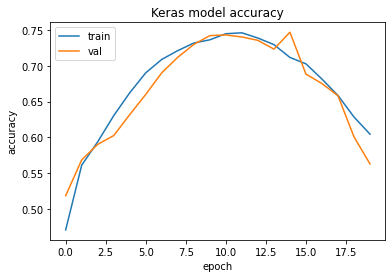

In [60]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

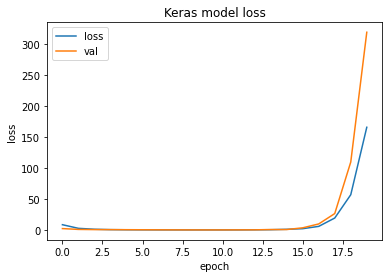

In [61]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [74]:
# Generate predictions
y_pred = model2.predict(X_val)

In [14]:
# Transform one hot encoding to a series of ints for confusion matrix

y_pred = np.argmax(y_pred, axis=1)
y_val_transformed = np.argmax(y_val, axis=1)

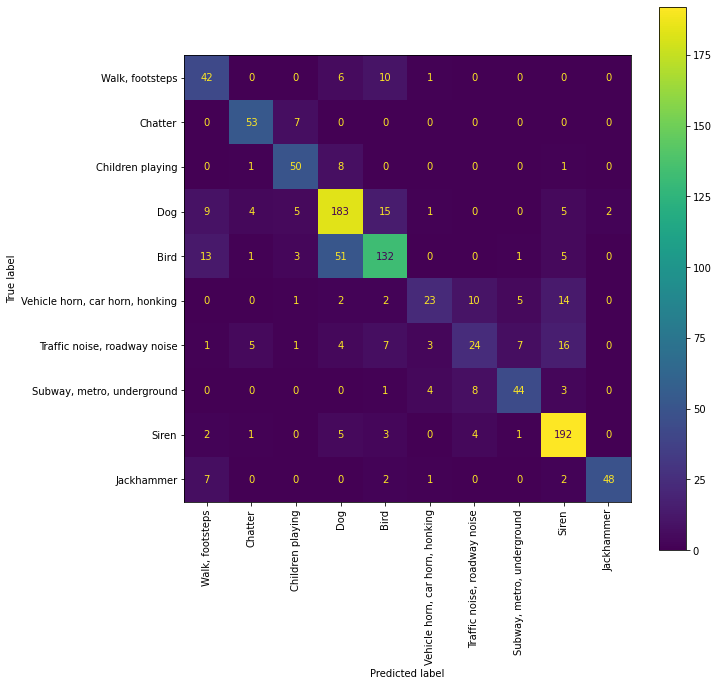

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_val_transformed, y_pred, display_labels=[classes_dict.get(n) for n in mlb.classes_], 
                              xticks_rotation='vertical', ax=ax)

### Same model with different batch size

In [62]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history4 = model2.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
17/17 [==============================] - 1s 52ms/step - loss: 1.0114 - accuracy: 0.6845 - auc: 0.9492 - val_loss: 0.8352 - val_accuracy: 0.7401 - val_auc: 0.9624
Epoch 2/100
17/17 [==============================] - 1s 48ms/step - loss: 1.0919 - accuracy: 0.6620 - auc: 0.9435 - val_loss: 0.8334 - val_accuracy: 0.7420 - val_auc: 0.9622
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 1.0077 - accuracy: 0.6948 - auc: 0.9513 - val_loss: 0.8298 - val_accuracy: 0.7458 - val_auc: 0.9624
Epoch 4/100
17/17 [==============================] - 1s 48ms/step - loss: 1.0162 - accuracy: 0.6808 - auc: 0.9470 - val_loss: 0.8267 - val_accuracy: 0.7486 - val_auc: 0.9627
Epoch 5/100
17/17 [==============================] - 1s 46ms/step - loss: 0.9572 - accuracy: 0.7042 - auc: 0.9525 - val_loss: 0.8236 - val_accuracy: 0.7495 - val_auc: 0.9631
Epoch 6/100
17/17 [==============================] - 1s 47ms/step - loss: 0.9792 - accuracy: 0.6995 - auc: 0.9497 - val_loss: 0.82

Epoch 48/100
17/17 [==============================] - 1s 57ms/step - loss: 0.8382 - accuracy: 0.7202 - auc: 0.9613 - val_loss: 0.7931 - val_accuracy: 0.7458 - val_auc: 0.9651
Epoch 49/100
17/17 [==============================] - 1s 51ms/step - loss: 0.8872 - accuracy: 0.7230 - auc: 0.9587 - val_loss: 0.7931 - val_accuracy: 0.7467 - val_auc: 0.9651
Epoch 50/100
17/17 [==============================] - 1s 41ms/step - loss: 0.8886 - accuracy: 0.7230 - auc: 0.9582 - val_loss: 0.7930 - val_accuracy: 0.7467 - val_auc: 0.9651
Epoch 51/100
17/17 [==============================] - 1s 31ms/step - loss: 0.9066 - accuracy: 0.7333 - auc: 0.9596 - val_loss: 0.7929 - val_accuracy: 0.7476 - val_auc: 0.9651
Epoch 52/100
17/17 [==============================] - 0s 27ms/step - loss: 0.8852 - accuracy: 0.7258 - auc: 0.9589 - val_loss: 0.7929 - val_accuracy: 0.7439 - val_auc: 0.9651
Epoch 53/100
17/17 [==============================] - 0s 25ms/step - loss: 0.9085 - accuracy: 0.7371 - auc: 0.9548 - val_loss

In [63]:
model2.save(f"{models_dir}keras_audio_batch64.tf")

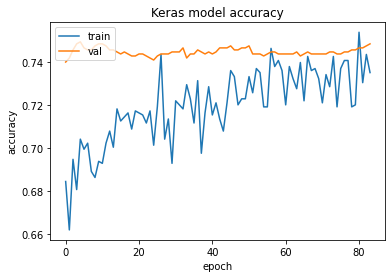

In [64]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

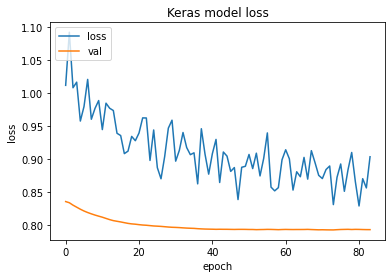

In [66]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [72]:
# Generate predictions
y_pred = model2.predict(X_val)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)

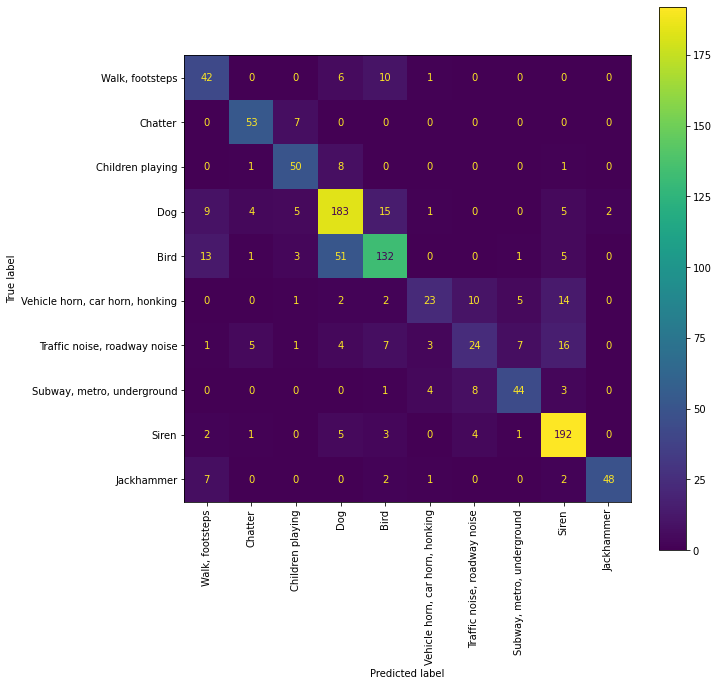

In [76]:
# Build confusion matrix

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_val_transformed, y_pred, display_labels=[classes_dict.get(n) for n in mlb.classes_], 
                              xticks_rotation='vertical', ax=ax)

## qiuqiangkong model
https://github.com/qiuqiangkong/audioset_classification

In [12]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, Lambda
import keras.backend as K
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)

def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

time_steps = 10
freq_bins = 128
classes_num = 10

# Hyper parameters
hidden_units = 1024
drop_rate = 0.5
batch_size = 500

# Embedded layers
input_layer = Input(shape=X[0].shape)

a1 = Dense(hidden_units)(input_layer)
a1 = BatchNormalization()(a1)
a1 = Activation('relu')(a1)
a1 = Dropout(drop_rate)(a1)

a2 = Dense(hidden_units)(a1)
a2 = BatchNormalization()(a2)
a2 = Activation('relu')(a2)
a2 = Dropout(drop_rate)(a2)

a3 = Dense(hidden_units)(a2)
a3 = BatchNormalization()(a3)
a3 = Activation('relu')(a3)
a3 = Dropout(drop_rate)(a3)
cla = Dense(hidden_units, activation='linear')(a3)
att = Dense(hidden_units, activation='sigmoid')(a3)

b1 = Lambda(attention_pooling, output_shape=pooling_shape)([cla, att])
b1 = BatchNormalization()(b1)
b1 = Activation(activation='relu')(b1)
b1 = Dropout(drop_rate)(b1)

output_layer = Dense(classes_num, activation='sigmoid')(b1)

model5 = keras.Model(inputs=input_layer, outputs=output_layer, name="qiuqiangkong")
# model5.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy", auroc])
model5.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model5.summary()

Model: "qiuqiangkong"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 10, 1024)     132096      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 10, 1024)    4096        ['dense_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 10, 1024)     0           ['batch_normalization_

### Train the model

In [13]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


history5 = model5.fit(
    X,
    y,
    batch_size=64, # batch size 1 doesn't work
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
913/913 [==============================] - 141s 153ms/step - loss: 0.1121 - accuracy: 0.7817 - val_loss: 0.1102 - val_accuracy: 0.7834
Epoch 2/100
913/913 [==============================] - 96s 106ms/step - loss: 0.0928 - accuracy: 0.8159 - val_loss: 0.1040 - val_accuracy: 0.7797
Epoch 3/100
913/913 [==============================] - 109s 120ms/step - loss: 0.0888 - accuracy: 0.8239 - val_loss: 0.1048 - val_accuracy: 0.7976
Epoch 4/100
913/913 [==============================] - 101s 111ms/step - loss: 0.0862 - accuracy: 0.8301 - val_loss: 0.0938 - val_accuracy: 0.8126
Epoch 5/100
913/913 [==============================] - 96s 105ms/step - loss: 0.0843 - accuracy: 0.8349 - val_loss: 0.0994 - val_accuracy: 0.7957
Epoch 6/100
913/913 [==============================] - 107s 118ms/step - loss: 0.0822 - accuracy: 0.8365 - val_loss: 0.0945 - val_accuracy: 0.8126
Epoch 7/100
913/913 [==============================] - 102s 111ms/step - loss: 0.0809 - accuracy: 0.8404 - val_loss: 0.0

In [14]:
model5.save(f"{models_dir}qiuqiangkong_b64.tf")
model5.save_weights(f"{models_dir}qiuqiangkong_b64_weights.tf")

INFO:tensorflow:Assets written to: ./models/qiuqiangkong_b64.tf\assets


In [15]:
model5.save(f"{models_dir}qiuqiangkong_b64.h5")
model5.save_weights(f"{models_dir}qiuqiangkong_b64_weights.hdf5")

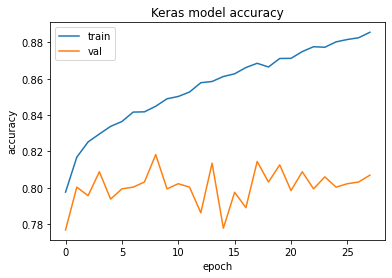

In [95]:
import matplotlib.pyplot as plt

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [97]:
# Generate predictions
y_pred = model5.predict(X_val)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)

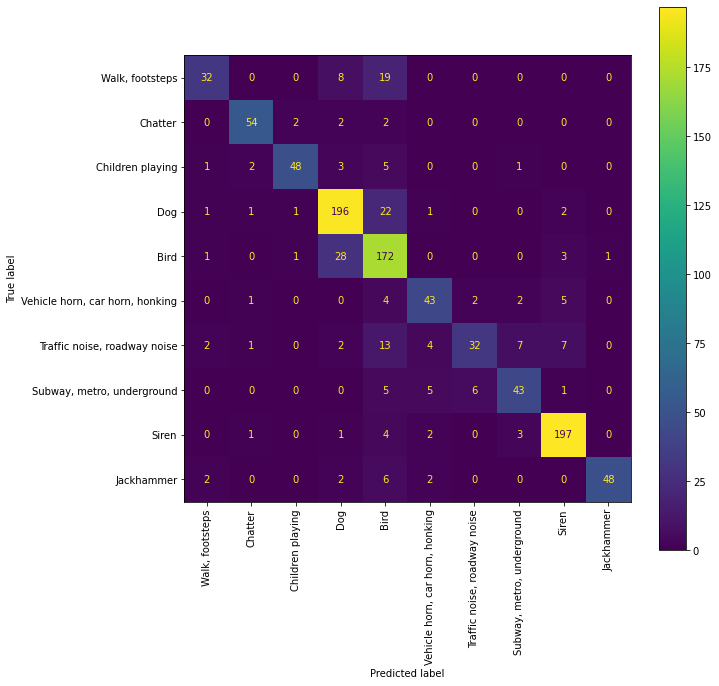

In [98]:
# Build confusion matrix

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_val_transformed, y_pred, display_labels=[classes_dict.get(n) for n in mlb.classes_], 
                              xticks_rotation='vertical', ax=ax)

### Same model, different batch size

In [6]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


history6 = model5.fit(
    X,
    y,
    batch_size=128,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
457/457 [==============================] - 31s 63ms/step - loss: 0.1142 - accuracy: 0.7808 - val_loss: 0.1225 - val_accuracy: 0.7646
Epoch 2/100
457/457 [==============================] - 53s 116ms/step - loss: 0.0918 - accuracy: 0.8188 - val_loss: 0.1069 - val_accuracy: 0.7872
Epoch 3/100
457/457 [==============================] - 117s 257ms/step - loss: 0.0872 - accuracy: 0.8267 - val_loss: 0.0972 - val_accuracy: 0.8051
Epoch 4/100
457/457 [==============================] - 129s 283ms/step - loss: 0.0844 - accuracy: 0.8316 - val_loss: 0.0960 - val_accuracy: 0.8136
Epoch 5/100
457/457 [==============================] - 148s 324ms/step - loss: 0.0823 - accuracy: 0.8355 - val_loss: 0.1024 - val_accuracy: 0.7966
Epoch 6/100
457/457 [==============================] - 155s 341ms/step - loss: 0.0802 - accuracy: 0.8412 - val_loss: 0.1050 - val_accuracy: 0.7957
Epoch 7/100
457/457 [==============================] - 155s 340ms/step - loss: 0.0787 - accuracy: 0.8446 - val_loss: 0.10

In [7]:
model5.save(f"{models_dir}qiuqiangkong_b128.tf")

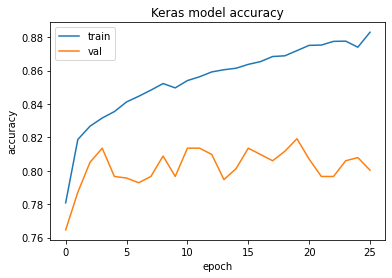

In [8]:
import matplotlib.pyplot as plt

plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

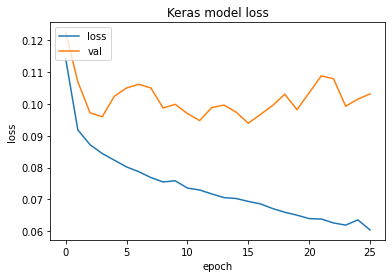

In [9]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [15]:
# Generate predictions
y_pred = model5.predict(X_val)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)

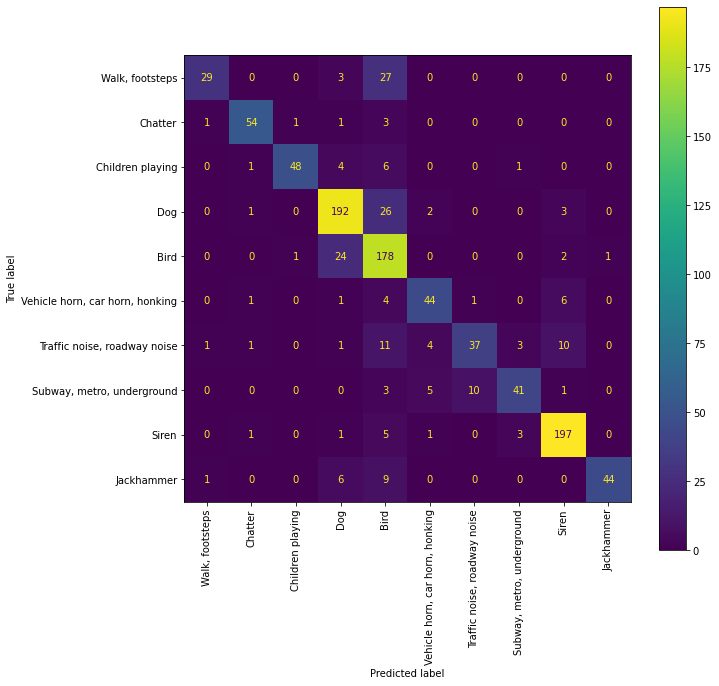

In [20]:
# Build confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_val_transformed, y_pred, display_labels=[classes_dict.get(n) for n in mlb.classes_], 
                              xticks_rotation='vertical', ax=ax)